# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [2]:
import os

import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.9.0


In [3]:
import matplotlib.pyplot as plt

## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [31]:
df = pd.read_csv("data/wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [32]:
df.date = pd.to_datetime(df.date)

In [6]:
df.shape

(383, 7)

In [7]:
plotly_df(df.set_index("date")[["count"]])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [8]:
from prophet import Prophet
import numpy as np

In [33]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

In [34]:
train_df.tail()

,ds,y
358,2015-12-17,2870
363,2015-12-18,2475
364,2015-12-19,1659
344,2015-12-20,1534
343,2015-12-21,2425


In [11]:
model = Prophet().fit(train_df)

21:12:52 - cmdstanpy - INFO - Chain [1] start processing
21:12:53 - cmdstanpy - INFO - Chain [1] done processing


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [12]:
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

In [13]:
forecast.set_index('ds').loc['2016-01-20']

trend                         2994.392590
yhat_lower                    3001.944149
yhat_upper                    3826.430673
trend_lower                   2970.392720
trend_upper                   3021.299995
additive_terms                 425.478691
additive_terms_lower           425.478691
additive_terms_upper           425.478691
weekly                         425.478691
weekly_lower                   425.478691
weekly_upper                   425.478691
multiplicative_terms             0.000000
multiplicative_terms_lower       0.000000
multiplicative_terms_upper       0.000000
yhat                          3419.871280
Name: 2016-01-20 00:00:00, dtype: float64

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [14]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 
                                   'yhat_upper']].join(df.set_index('ds'))

In [15]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = cmp_df['e'] / cmp_df['y']

In [16]:
MAPE = np.mean(np.abs(cmp_df['p'][-30:]))
MAE = np.mean(np.abs(cmp_df['e'][-30:]))

In [17]:
print(f"{round(MAPE*100,2)}% - MAPE\n{round(MAE,2)} - MAE")

34.27% - MAPE
594.91 - MAE


## Предсказываем с помощью ARIMA

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [19]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train_df['y'])

print(f'p-value = {adf_test[1]}') # Нет, не является

p-value = 0.10739219627612051


In [36]:
train_df = train_df.set_index("ds")

In [39]:
train_df

,y
ds,
2015-01-01,1414
2015-01-02,1920
2015-01-03,1338
2015-01-04,1404
2015-01-05,2264
...,...
2015-12-17,2870
2015-12-18,2475
2015-12-19,1659


**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [26]:
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.seasonal import seasonal_decompose

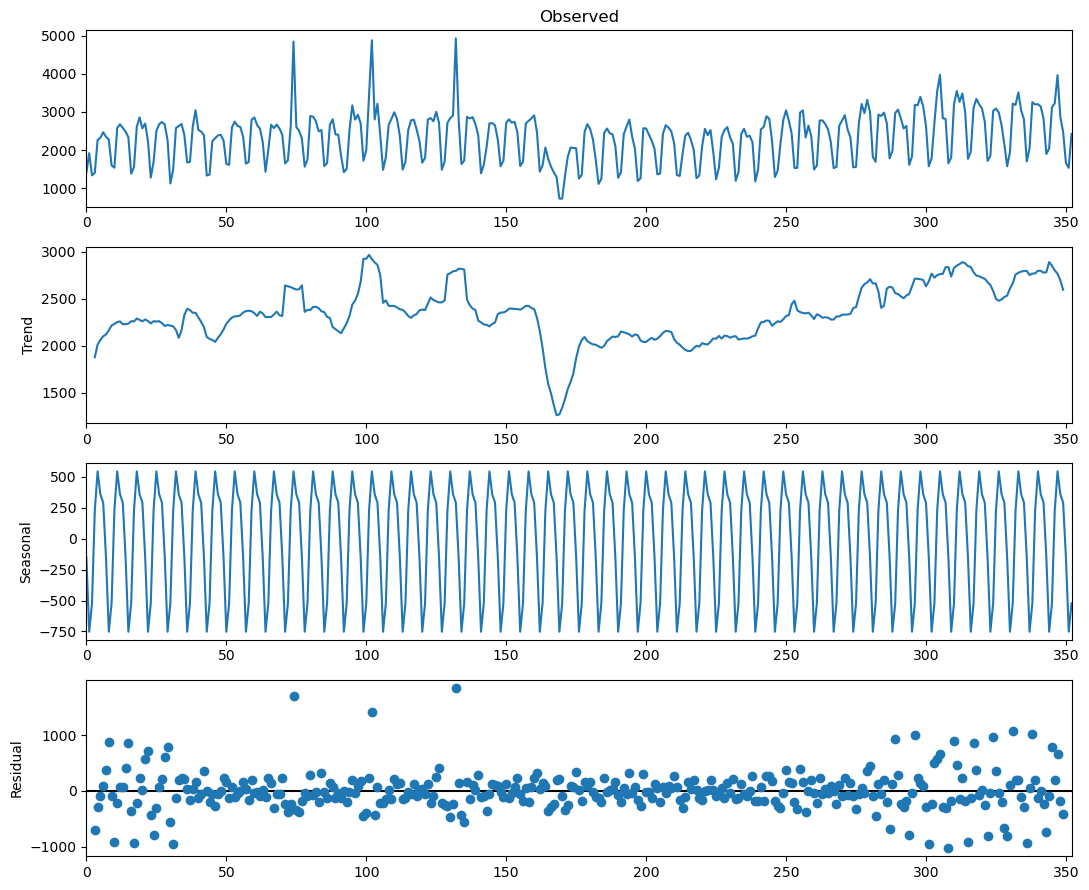

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
seasonal_decompose(train_df['y'].values, period=7).plot();

In [49]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)

Критерий Дики-Фуллера: p=0.000000


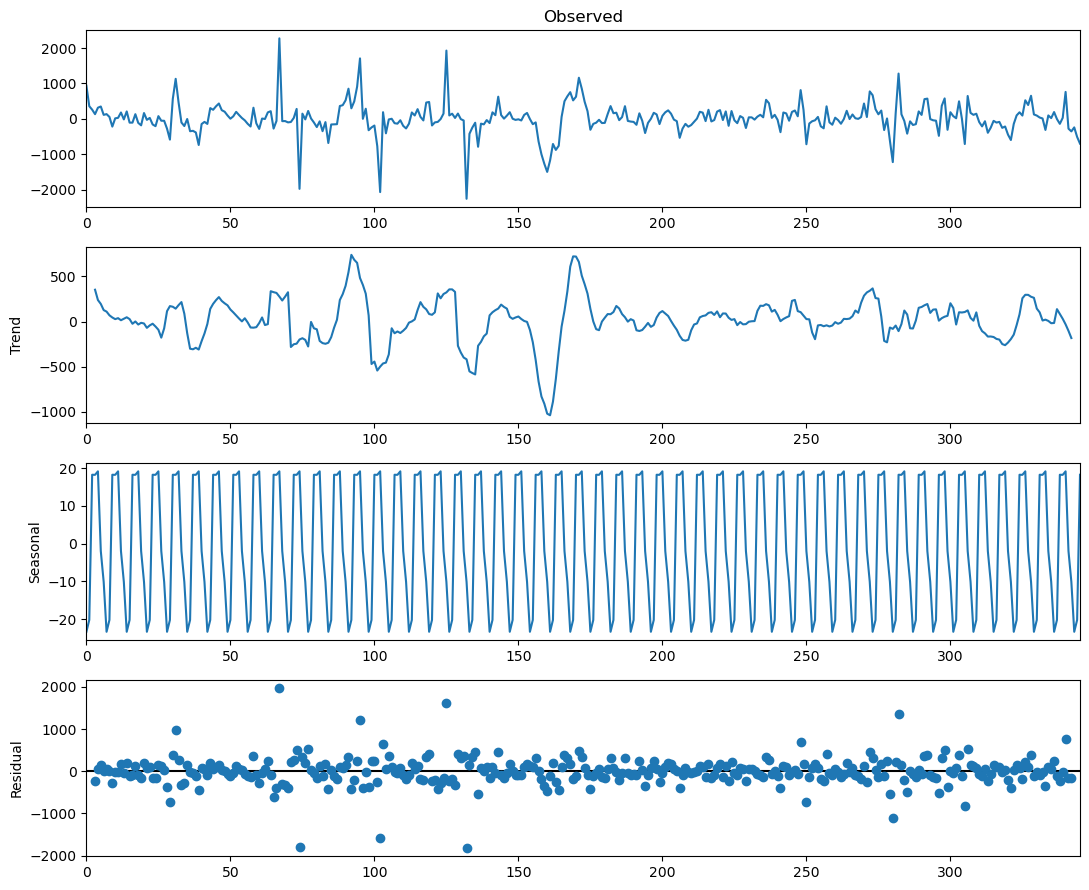

In [70]:
seasonal_decompose(train_df['y_diff'][7:].values, period=7).plot()
print("Критерий Дики-Фуллера: p=%f" % adfuller(train_df.y_diff[8:])[1])

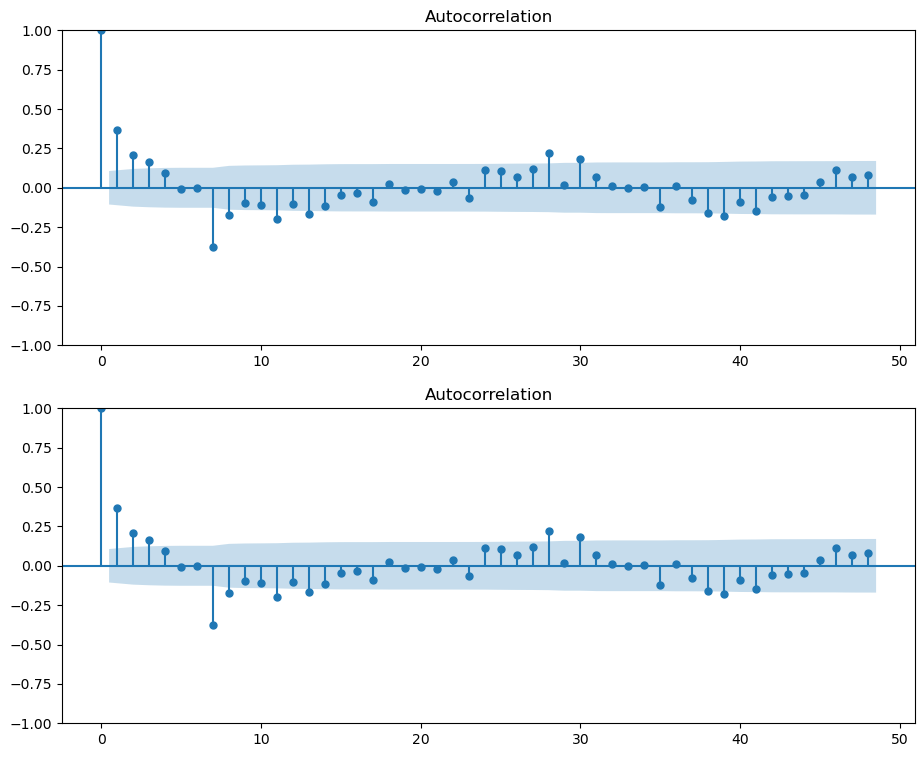

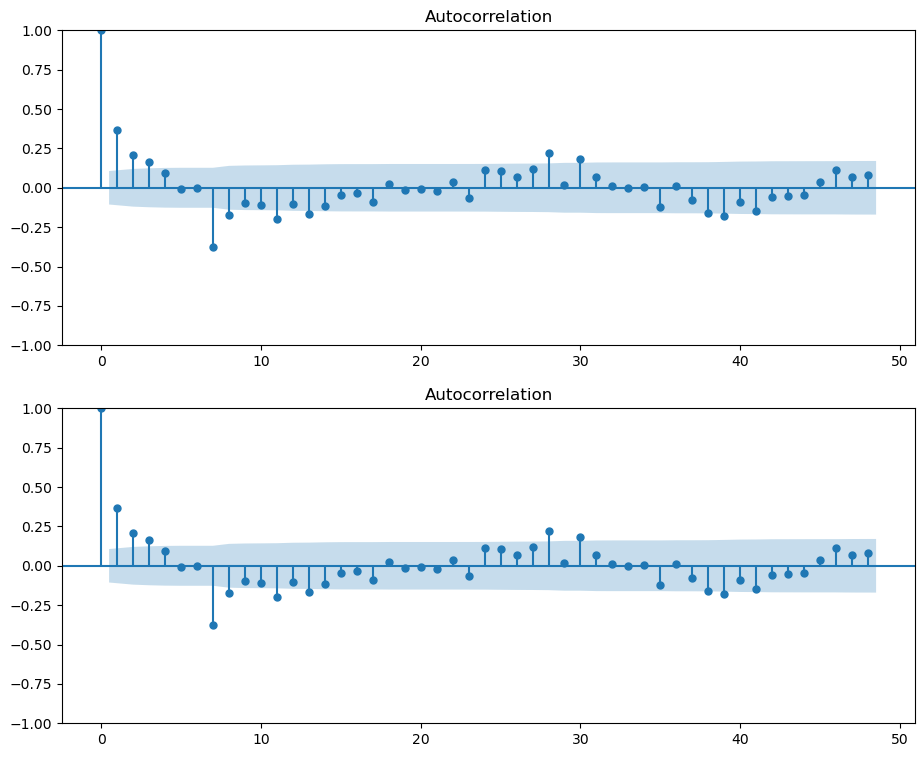

In [73]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [74]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [75]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [09:59<00:00,  1.56s/it]


In [100]:
result_table1 = pd.DataFrame(results1).rename({0:"params", 1:'aic'}, axis=1)

In [106]:
result_table1[result_table1['params'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,params,aic
256,"(1, 0, 2, 3, 0, 0)",5183.820817
258,"(1, 0, 2, 3, 1, 0)",5022.312524
355,"(1, 1, 2, 3, 1, 1)",5019.555903
357,"(1, 1, 2, 3, 2, 1)",4988.974747


In [103]:
print(result_table1.sort_values(by = 'aic', ascending=True).head())

                 params   aic
42   (0, 0, 1, 3, 0, 0)  10.0
43   (0, 0, 1, 3, 0, 1)  12.0
351  (1, 1, 2, 2, 2, 1)  14.0
67   (0, 0, 2, 3, 0, 1)  14.0
91   (0, 0, 3, 3, 0, 1)  16.0


In [107]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.732841


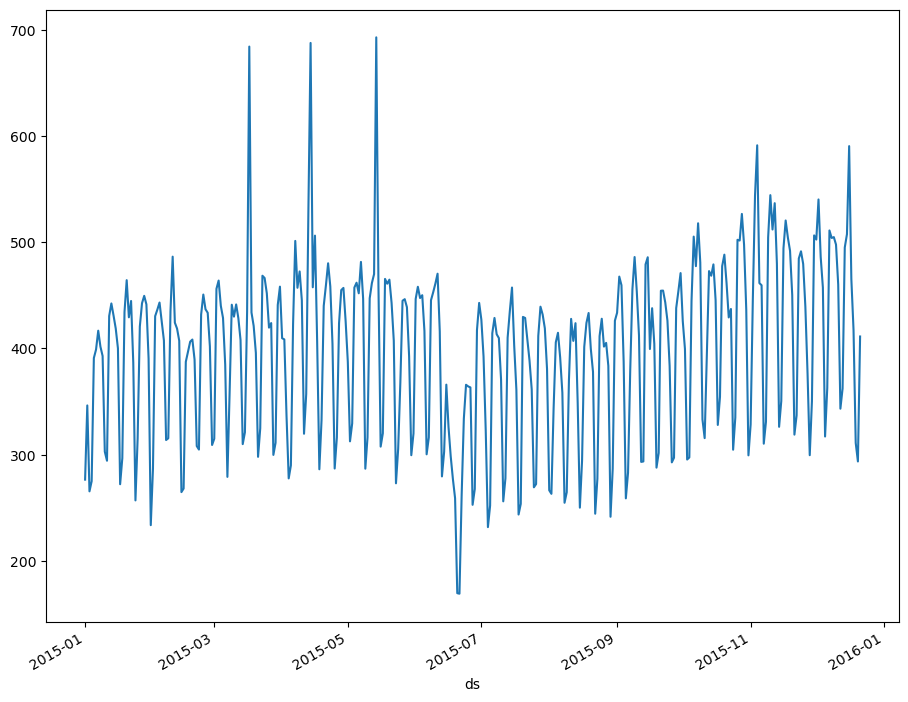

In [115]:
train_df['y_box'].plot();

In [118]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

  0%|                                                                                          | 0/384 [00:00<?, ?it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

  1%|▍                                                                                 | 2/384 [00:00<00:39,  9.68it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

  1%|▊                                                                                 | 4/384 [00:00<

D:\Program files\ana3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 11%|█████████                                                                        | 43/384 [00:22<06:26,  1.13s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

 11%|█████████▎                                                                       | 44/384 [00:25<08:43,  1.54s/it]D:\Program files\a

D:\Program files\ana3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 22%|█████████████████▉                                                               | 85/384 [01:15<07:50,  1.57s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 22%|██████████████████▏                                                              | 86/384 [01:17<08:55,  1.80s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 23%|██████████████████▎                                                              | 87/384 [01:18<07:00,  1.41s/it]D:\Program files\ana3\lib\site-packages\

 34%|███████████████████████████▎                                                    | 131/384 [01:53<01:30,  2.80it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 34%|███████████████████████████▌                                                    | 132/384 [01:54<01:57,  2.14it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 35%|███████████████████████████▋                                                    | 133/384 [01:54<01:52,  2.22it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.

 40%|███████████████████████████████▉                                                | 153/384 [02:18<03:09,  1.22it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 40%|████████████████████████████████                                                | 154/384 [02:19<03:23,  1.13it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 40%|████████████████████████████████▎                                               | 155/384 [02:20<03:41,  1.04it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.

 46%|████████████████████████████████████▍                                           | 175/384 [02:53<03:18,  1.05it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 46%|████████████████████████████████████▋                                           | 176/384 [02:54<03:30,  1.01s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 46%|████████████████████████████████████▉                                           | 177/384 [02:55<02:54,  1.19it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.

 58%|██████████████████████████████████████████████                                  | 221/384 [03:56<01:32,  1.77it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 58%|██████████████████████████████████████████████▎                                 | 222/384 [03:57<01:47,  1.51it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 58%|██████████████████████████████████████████████▍                                 | 223/384 [03:58<01:41,  1.59it/s]D:\Program files\ana

 63%|██████████████████████████████████████████████████▋                             | 243/384 [04:24<02:31,  1.08s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 64%|██████████████████████████████████████████████████▊                             | 244/384 [04:25<02:10,  1.07it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 64%|███████████████████████████████████████████████████                             | 245/384 [04:25<01:46,  1.30it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.

 69%|███████████████████████████████████████████████████████                         | 264/384 [05:11<10:34,  5.29s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 69%|███████████████████████████████████████████████████████▏                        | 265/384 [05:11<07:38,  3.85s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. U

 73%|██████████████████████████████████████████████████████████▏                     | 279/384 [05:29<02:46,  1.59s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 73%|██████████████████████████████████████████████████████████▎                     | 280/384 [05:31<02:50,  1.64s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA paramet

 77%|█████████████████████████████████████████████████████████████▍                  | 295/384 [06:09<01:45,  1.18s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 77%|█████████████████████████████████████████████████████████████▋                  | 296/384 [06:10<01:30,  1.03s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 77%|█████████████████████████████████████████████████████████████▉                  | 297/384 [06:10<01:10,  1.24it/s]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.

 89%|███████████████████████████████████████████████████████████████████████         | 341/384 [07:07<00:58,  1.35s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 89%|███████████████████████████████████████████████████████████████████████▎        | 342/384 [07:09<01:00,  1.45s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters foun

D:\Program files\ana3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 93%|██████████████████████████████████████████████████████████████████████████▍     | 357/384 [07:44<01:30,  3.37s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Program files\ana3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 93%|██████████████████████████████████████████████████████████████████████████▌     | 358/384 [07:49<01:36,  3.71s/it]D:\Program files\ana3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

D:\Program files\ana3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [09:16<00:00,  1.45s/it]


In [119]:
results2

[[(0, 0, 0, 0, 0, 0), 5242.970472673438],
 [(0, 0, 0, 0, 0, 1), 4860.099955931378],
 [(0, 0, 0, 0, 1, 0), 3735.5624959513293],
 [(0, 0, 0, 0, 1, 1), 3652.379847549493],
 [(0, 0, 0, 0, 2, 0), 4000.6973858952706],
 [(0, 0, 0, 0, 2, 1), 3695.513496541005],
 [(0, 0, 0, 1, 0, 0), 3839.611325396082],
 [(0, 0, 0, 1, 0, 1), 3758.1265803350707],
 [(0, 0, 0, 1, 1, 0), 3687.6094485340886],
 [(0, 0, 0, 1, 1, 1), 3653.985401532583],
 [(0, 0, 0, 1, 2, 0), 3859.149397994464],
 [(0, 0, 0, 1, 2, 1), 3652.0627731999266],
 [(0, 0, 0, 2, 0, 0), 3792.6594660151795],
 [(0, 0, 0, 2, 0, 1), 3759.754700128711],
 [(0, 0, 0, 2, 1, 0), 3660.5577662381966],
 [(0, 0, 0, 2, 1, 1), 3651.7235892478407],
 [(0, 0, 0, 2, 2, 0), 3787.4787800613426],
 [(0, 0, 0, 2, 2, 1), 3627.7119417494223],
 [(0, 0, 0, 3, 0, 0), 3766.07543589572],
 [(0, 0, 0, 3, 0, 1), 3757.4542765492924],
 [(0, 0, 0, 3, 1, 0), 3643.982759033411],
 [(0, 0, 0, 3, 1, 1), 3643.9181431321726],
 [(0, 0, 0, 3, 2, 0), 3691.4124527352324],
 [(0, 0, 0, 3, 2, 1), 